In [6]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "GFS Artemisia"
plt.rcParams['mathtext.fontset'] = "cm"

In [24]:
class SingleFilter(object):
    """Single filter class."""

    def __init__(self, band):
        """
        Parameters
        ----------
        band: str
            Name of the band.
        """
        self.name = band
        self._add_filter(band)

    def __repr__(self):
        rep = (
            f"name: {self.name}, eff_wave: {self.eff_wave:.1f} Å,"
        )
        return rep

    def __getitem__(self, item):
        return getattr(self, item)

    def _add_filter(self, filt_name):
        """Adds a filter from the available filters library.

        Parameters
        ----------
        filt_name: str
            Name of the filter.
        """
        filt_pattern = os.path.join("filters", "*", f"{filt_name}.dat")
        filt_file = glob.glob(filt_pattern, recursive=True)

        err_message = (
            "No filter file or multiple files with "
            f"the pattern {filt_pattern} found."
        )
        assert len(filt_file) == 1, err_message

        filt_file = filt_file[0]
        self.filt_file = filt_file
        self.wave, self.transmission = np.loadtxt(filt_file).T
        self.eff_wave = self.calc_eff_wave()

    def calc_eff_wave(self, sed_wave=None, sed_flux=None):
        """Calculates the effective wavelength.

        The effective wavelength depends on the shape
        of the given SED.

        Parameters
        ----------
        sed_wave : array-like, default ``None``
            SED's wavelength range. If ``None``, a flat SED is used.
        sed_flux : array-like, default ``None``
            SED's flux density distribution. If ``None``, a flat SED is used.

        Returns
        -------
        eff_wave: float
            Effective wavelength.
        """
        if sed_wave is None or sed_flux is None:
            sed_wave = self.wave.copy()
            sed_flux = 100 * np.ones_like(sed_wave)

        transmission = self.transmission.copy()
        transmission = np.interp(sed_wave, self.wave, transmission, left=0.0, right=0.0)
        I1 = np.trapz((sed_wave**2) * transmission * sed_flux, sed_wave)
        I2 = np.trapz(sed_wave * transmission * sed_flux, sed_wave)
        eff_wave = I1 / I2

        return eff_wave

    def integrate_filter(self, sed_wave, sed_flux):
        """Calculates the flux density of an SED given a filter response.

        Parameters
        ----------
        sed_wave : array-like
            SED's wavelength range.
        sed_flux : array-like
            SED's flux density distribution.

        Returns
        -------
        flux_filter : float
            Flux density.
        """
        blue_edge_covered = sed_wave.min() <= self.wave.min()
        red_edge_covered = sed_wave.max() >= self.wave.max()
        err_message = f"The SED does not completely overlap with {self.name} filter."
        assert blue_edge_covered and red_edge_covered, err_message

        transmission = self.transmission.copy()
        transmission = np.interp(sed_wave, self.wave, transmission, left=0.0, right=0.0)
        I1 = np.trapz(sed_flux * transmission * sed_wave, sed_wave)
        I2 = np.trapz(self.transmission * self.wave, self.wave)
        flux_filter = I1 / I2

        return flux_filter

class MultiFilters(object):
    """Class representing multiple filters."""

    def __init__(self, bands):
        """
        Parameters
        ----------
        bands: list-like
            Bands to include.
        """
        self.bands = list(bands).copy()

        for band in bands:
            if band in "UBVRI":
                filt_name = f"Bessell_{band}"
            elif band in "ugriz":
                filt_name = f"sdss_{band}"
            elif band in "YJHK":
                filt_name = f"UKIRT_{band}"
            single_filt = SingleFilter(filt_name)
            setattr(self, band, single_filt)

    def __repr__(self):
        return str(self.bands)

    def __getitem__(self, item):
        return getattr(self, item)

    def _add_filter(self, band):
        """Adds a band object with a single-filter class.

        Parameters
        ----------
        band: str
            Name of the band.
        """
        if band not in self.bands:
            single_filt = SingleFilter(band)
            setattr(self, band, single_filt)
            self.bands.append(band)

    def remove_filter(self, band):
        """Removes a band object.

        Parameters
        ----------
        band: str
            Name of the band.
        """
        err_message = f"Filter not found: {self.bands}"
        assert band in self.bands, err_message

        delattr(self, band)
        self.bands.remove(band)

    def calc_eff_wave(self, bands=None, sed_wave=None, sed_flux=None):
        """Calculates the effective wavelength of multiple bands.

        The effective wavelength depends on the shape
        of the given SED.

        Parameters
        ----------
        bands: list-like, default ``None``
            Bands for calculating their effective wavelengths. If ``None``,
            use of the available bands.
        sed_wave : array-like, default ``None``
            SED's wavelength range. If ``None``, a flat SED is used.
        sed_flux : array-like, default ``None``
            SED's flux density distribution. If ``None``, a flat SED is used.
        """
        if not bands:
            bands = self.bands

        for band in bands:
            self[band].calc_eff_wave(sed_wave, sed_flux)

    def plot_filters(self, bands=None):
        """Plot the filters' transmission functions.

        Parameters
        ----------
        bands : list, default ``None``
            Bands to plot. If ``None``, plots all the available bands.
        """
        if not bands:
            bands = self.bands

        fig, ax = plt.subplots(figsize=(8, 6))
        for band in bands:
            norm = self[band]["transmission"].max()
            ax.plot(self[band]["wave"], self[band]["transmission"] / norm, label=band)

        ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=18, family="serif")
        ax.set_ylabel("Normalised Transmission Function", fontsize=18, family="serif")
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.minorticks_on()
        ax.tick_params(
            which="major", length=6, width=1, direction="in", top=True, right=True
        )
        ax.tick_params(
            which="minor", length=3, width=1, direction="in", top=True, right=True
        )
        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=14)

        plt.show()

In [26]:
class SEDTemplate(object):
    """Spectral energy distribution (SED) class.
    """

    def __init__(self, z=0.0, template="SNIa", bands=None):
        """
        Parameters
        ----------
        z: float, default ``0.0``
            Redshift.
        template: str, default ``SNIa``
            Template name. E.g., ``SNIa``, ``SNII``, etc.
        bands: str, default ``None``
            Bands to use. Default, use all bands.
        """
        self.z = z
        if bands is None:
            bands = 'UBVRI'+'ugriz'+'YJHK'
        self.filters = MultiFilters(bands)
        self._set_sed_template(template)
        self._redshift()
        self._calculate_k_correction()

    def __repr__(self):
        return f"name: {self.name}, z: {self.z:.5}"

    def __getitem__(self, item):
        return getattr(self, item)

    def _set_sed_template(self, template):
        """Sets the SED template to be used for the mangling function.

        Parameters
        ----------
        template : str
            Template name. E.g., ``SNIa``, ``SNII``, etc.
        """
        # This can be modified to accept other templates
        if template == "SNIa":
            template_file = "lu23_sBV1.0_sed_template.dat"
        elif template == "SNII":
            template_file = "dessart_m15ml1_sed_template.dat"
        sed_file = os.path.join("sed_templates", template_file)
        self.data = pd.read_csv(
            sed_file, delim_whitespace=True, names=["phase", "wave", "flux"]
        )
        self.phase = self.data.phase.values
        self.rest_phase = self.data.phase.values
        self.rest_wave = self.data.wave.values
        self.rest_flux = self.data.flux.values
        self.rest_flux /= self.rest_flux.max()
        self.name = template

    def _redshift(self):
        """Redshifts the SED template."""

        self.obs_phase = self.rest_phase * (1 + self.z)
        self.obs_wave = self.rest_wave * (1 + self.z)
        self.obs_flux = self.rest_flux / (1 + self.z)

    def get_phase_data(self, phase):
        """Extracts the SED data for a given phase.

        The phase is given by the epochs of the SED template.

        Parameters
        ----------
        phase: int or float
            Phase of the SED.

        Returns
        -------
        rest_wave: array-like
            SED's rest-frame wavelength range at the given phase.
        rest_flux: array-like
            SED's rest-frame flunx density at the given phase.
        obs_wave: array-like
            SED's observer-frame wavelength range at the given phase.
        obs_flux: array-like
            SED's observer-frame flunx density at the given phase.
        """
        mask = self.rest_phase == phase
        rest_wave, rest_flux = self.rest_wave[mask].copy(), self.rest_flux[mask].copy()
        obs_wave, obs_flux = self.obs_wave[mask].copy(), self.obs_flux[mask].copy()

        return rest_wave, rest_flux, obs_wave, obs_flux

    def plot_sed(self, phase=0.0, bands=None):
        """Plots the SED template at the given phase.

        The SED is shown at its current state, e.g. redshifted
        and/or extincted.

        Parameters
        ----------
        phase: int or float
            Phase of the SED.
        bands: str, default ``None``
            Bands to plot.
        """
        err_message = f"Phase not found: {np.unique(self.phase)}"
        assert phase in self.phase, err_message

        rest_wave, rest_flux, obs_wave, obs_flux = self.get_phase_data(phase)
        
        fig, ax = plt.subplots(figsize=(8, 6))

        ax.plot(rest_wave, rest_flux, label='Rest-frame SED', 
                lw=2, ls='dotted', color='k')
        ax.plot(obs_wave, obs_flux, label='Observer-frame SED', 
                lw=2, color='red')
        
        if bands is not None:
            for band in bands:
                filt_wave = sed.filters[band].wave
                filt_trans = sed.filters[band].transmission
                filt_trans /= filt_trans.max()
                ax.plot(filt_wave, filt_trans*rest_flux.max(), label=band, 
                        lw=2, alpha=0.5, ls='dashed', zorder=20)
        
        ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=18, family="serif")
        ax.set_ylabel("Normalised Flux", fontsize=18, family="serif")
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.minorticks_on()
        ax.tick_params(
            which="major", length=6, width=1, direction="in", top=True, right=True
        )
        ax.tick_params(
            which="minor", length=3, width=1, direction="in", top=True, right=True
        )
        ax.legend(fontsize=14)

        plt.show()

    def _calculate_k_correction(self, phases=None):
        """Calculates the multi-colour light curves of the SED as if
        it were observed by a telescope.
        
        Parameters
        ----------
        phases: array
            Phases of the SED to use.
        """
        # obs. light curves
        k_correction = {band: [] for band in self.filters.bands}
        if phases is None:
            phases = np.unique(self.phase)
            
        for band in self.filters.bands:
            for phase in phases:
                rest_wave, rest_flux, obs_wave, obs_flux = self.get_phase_data(phase)
                rest_flux = self.filters[band].integrate_filter(rest_wave, rest_flux)
                obs_flux = self.filters[band].integrate_filter(obs_wave, obs_flux)
                obs_flux *= (1+self.z)
                kcorr = -2.5*np.log10(rest_flux/obs_flux)
                k_correction[band].append(kcorr)

        k_correction["phase"] = phases
        k_correction_df = pd.DataFrame(k_correction)
        self.kcorr = k_correction_df
        
    def plot_k_correction(self):
        """Plots the K correction.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        
        phases = self.kcorr.phase.values
        for band in self.kcorr.columns:
            if band == 'phase':
                continue
            kcorr = self.kcorr[band].values
            ax.plot(phases, kcorr, label=band, lw=2)
        
        ax.set_xlabel(r"Phase (days)", fontsize=18, family="serif")
        ax.set_ylabel(r"$K$-correction (mag)", fontsize=18, family="serif")
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.minorticks_on()
        ax.tick_params(
            which="major", length=6, width=1, direction="in", top=True, right=True
        )
        ax.tick_params(
            which="minor", length=3, width=1, direction="in", top=True, right=True
        )
        plt.legend(fontsize=14)

        plt.show()
        
    def kcorr_evolution(self, bands, z_range=None):
        """Plots the K-correction evolution.
        
        Parameters
        ----------
        bands: str
            Bands to plot.
        z_range: array
            Redshift range to use.
        """
        # values at peak luminosity (phase = 0.0)
        rest_wave, rest_flux, _, _ = self.get_phase_data(0.0)
        min_wave, max_wave = rest_wave.min(), rest_wave.max()
        
        if z_range is None:
            z_range = np.arange(0, 0.33, 0.03)
        z_init = self.z
        
        # for plotting
        z_plot = []
        kcorr_plot = {band:[] for band in bands}
        # for the y-axis limits
        self.z = z_range.max()
        self._redshift()
        self._calculate_k_correction(phases=[0.0])
        mask = self.kcorr.phase.values == 0.0
        kcorr_4_limits = [self.kcorr[band].values[mask][0] 
                          for band in bands]
        ymin = np.min(kcorr_4_limits)
        ymax = np.max(kcorr_4_limits)
        
        for z in z_range:
            self.z = z
            self._redshift()
            self._calculate_k_correction(phases=[0.0])
            
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # spectrum
            ax = axes[0]
            rest_wave, rest_flux, obs_wave, obs_flux = self.get_phase_data(0.0)
        
            ax.plot(rest_wave, rest_flux, label='Rest-frame SED', 
                    lw=2, ls='dotted', color='k')
            ax.plot(obs_wave, obs_flux, label='Observer-frame SED', 
                    lw=2, color='red')

            if bands is not None:
                for band in bands:
                    filt_wave = sed.filters[band].wave
                    filt_trans = sed.filters[band].transmission
                    filt_trans /= filt_trans.max()
                    ax.plot(filt_wave, filt_trans*rest_flux.max(), label=band, 
                            lw=2, alpha=0.5, ls='dashed', zorder=20)

            ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=18, family="serif")
            ax.set_ylabel("Normalised Flux", fontsize=18, family="serif")
            ax.xaxis.set_tick_params(labelsize=16)
            ax.yaxis.set_tick_params(labelsize=16)
            ax.minorticks_on()
            ax.tick_params(
                which="major", length=6, width=1, direction="in", top=True, right=True
            )
            ax.tick_params(
                which="minor", length=3, width=1, direction="in", top=True, right=True
            )
            ax.legend(fontsize=14)
            ax.set_xlim(min_wave, max_wave)
            
            # K-correction
            ax = axes[1]
            mask = self.kcorr.phase.values == 0.0
            z_plot.append(z)
            for band in bands:
                kcorr = self.kcorr[band].values[mask][0]
                kcorr_plot[band].append(kcorr)
                ax.plot(z_plot, kcorr_plot[band], label=band, lw=2)
            
            ax.set_xlabel(r"$z$", fontsize=18, family="serif")
            ax.set_ylabel(r"$K$-correction (mag)", fontsize=18, family="serif")
            ax.xaxis.set_tick_params(labelsize=16)
            ax.yaxis.set_tick_params(labelsize=16)
            ax.minorticks_on()
            ax.tick_params(
                which="major", length=6, width=1, direction="in", top=True, right=True
            )
            ax.tick_params(
                which="minor", length=3, width=1, direction="in", top=True, right=True
            )
            ax.legend(fontsize=14)
            ax.set_xlim(z_range.min(), z_range.max())
            ax.set_ylim(ymin, ymax)
            
            plt.savefig(f'plots/kcorr_z{str(z)}.png')
            plt.show()
            
        # create video
        image_folder = 'plots'
        video_name = 'kcorr_video.avi'

        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        images = np.sort(images)
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, 1, (width,height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
            
        # return to inital setup
        self.z = z_init
        self._redshift()
        self._calculate_k_correction()

In [29]:
z = 0.01
sed = SEDTemplate(z, 'SNIa', bands='BVYJH')

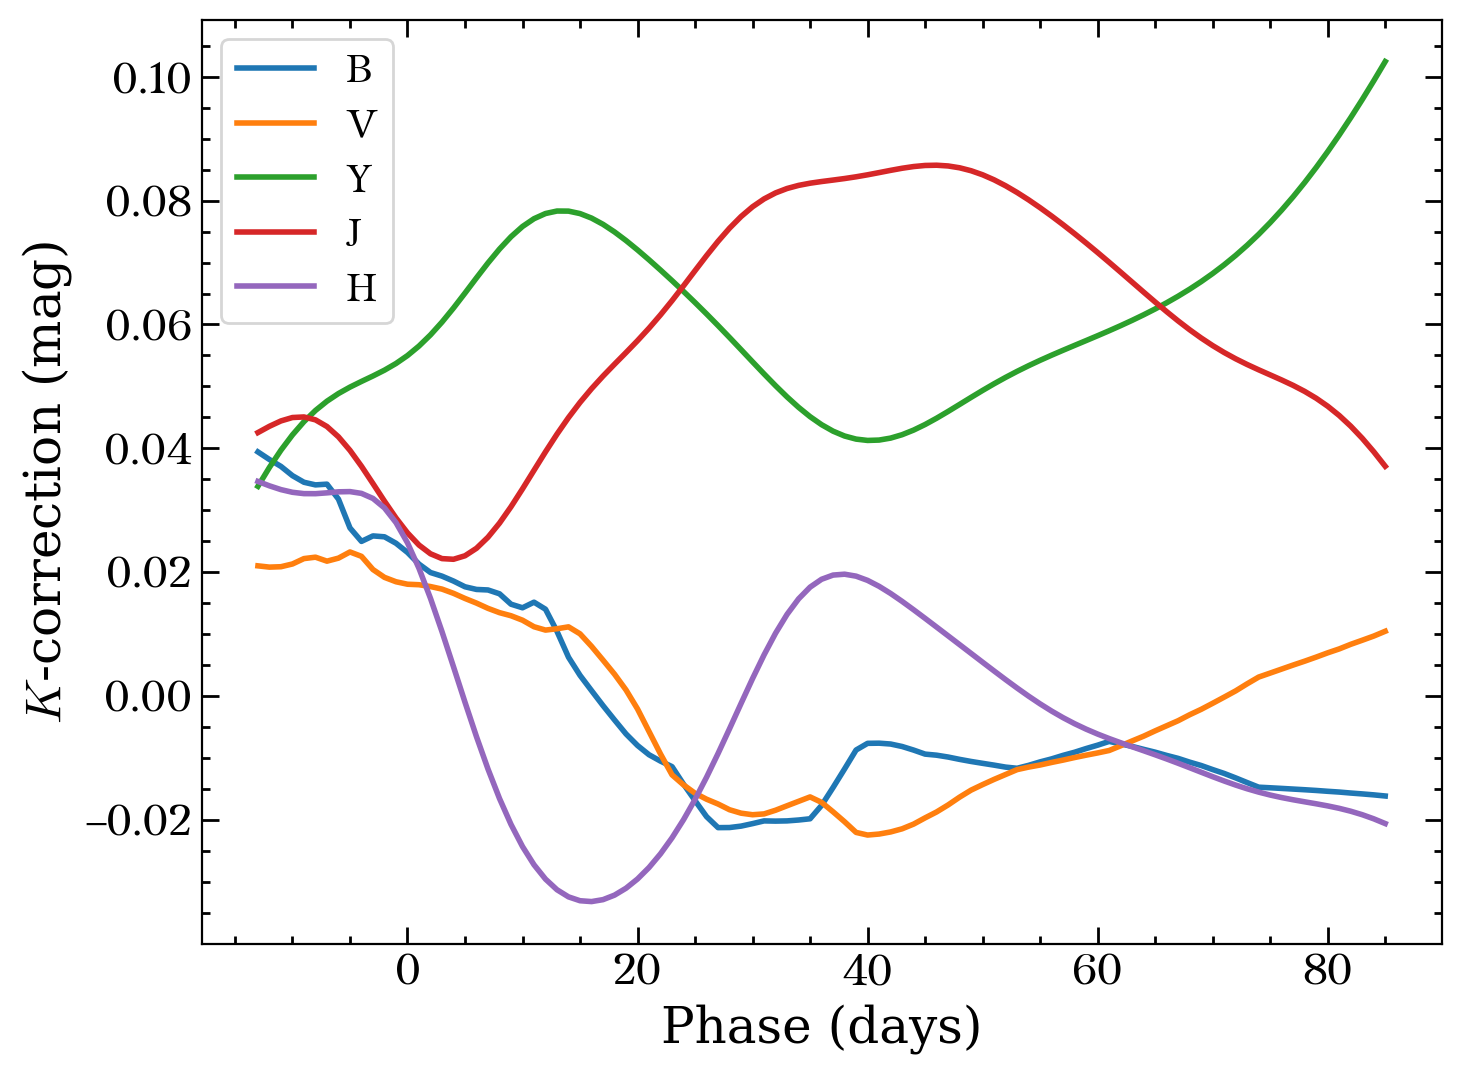

In [30]:
sed.plot_k_correction()

In [32]:
z = 0.03
sed = SEDTemplate(z, 'SNIa', bands='BVYJH')

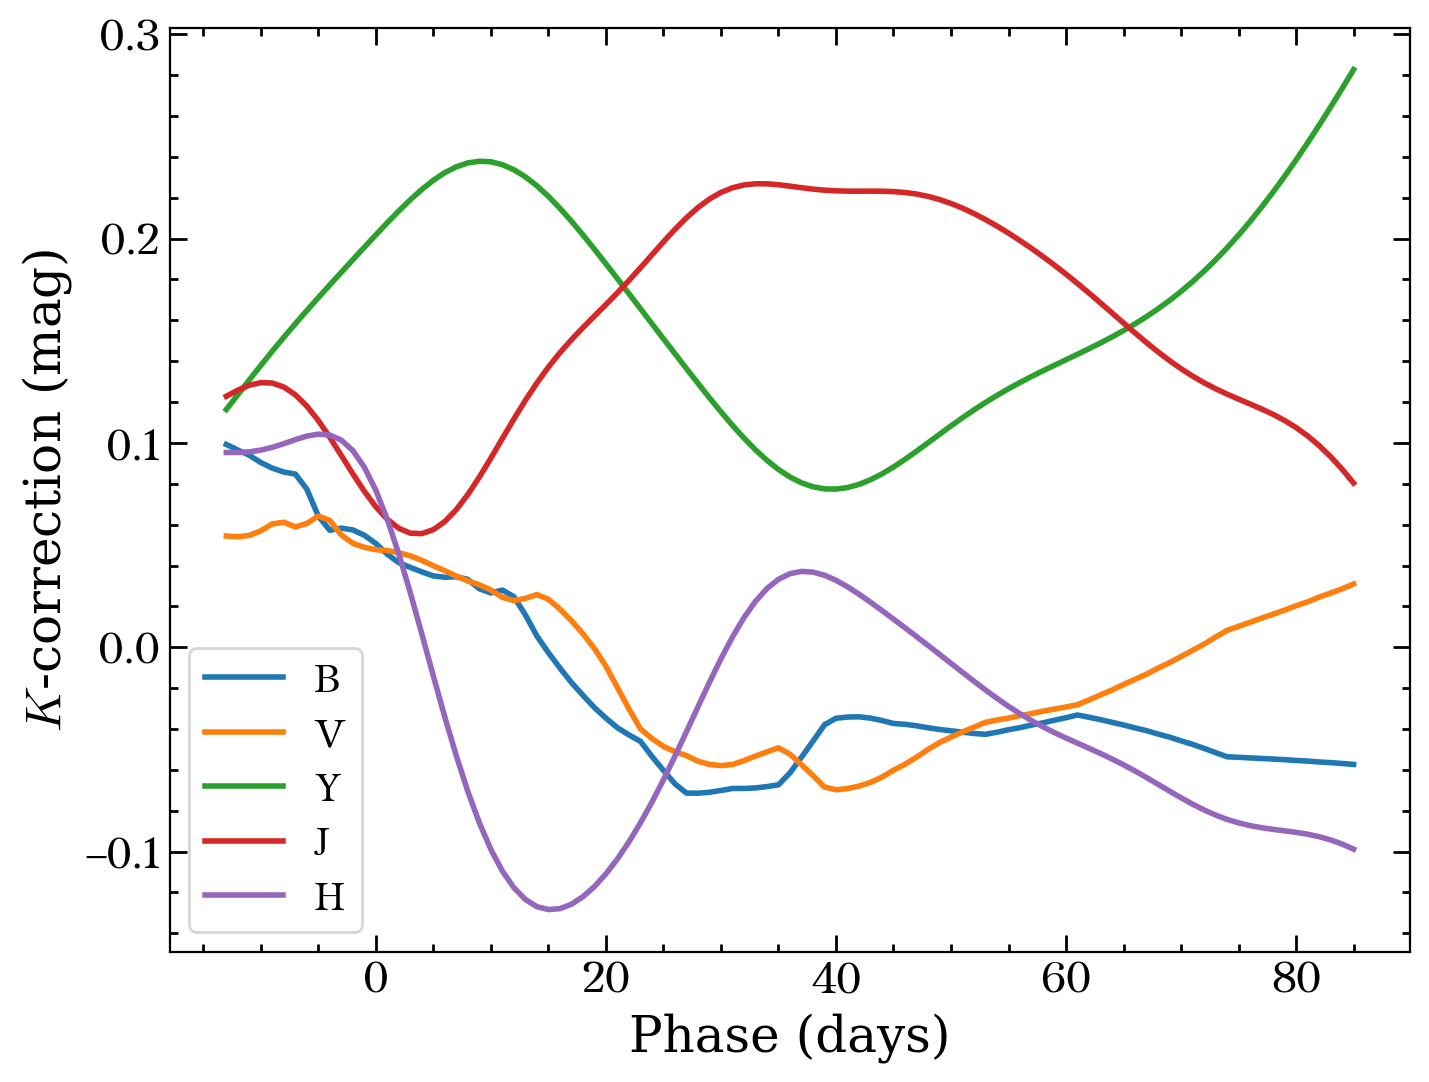

In [33]:
sed.plot_k_correction()

In [34]:
z = 0.05
sed = SEDTemplate(z, 'SNIa', bands='BVYJH')

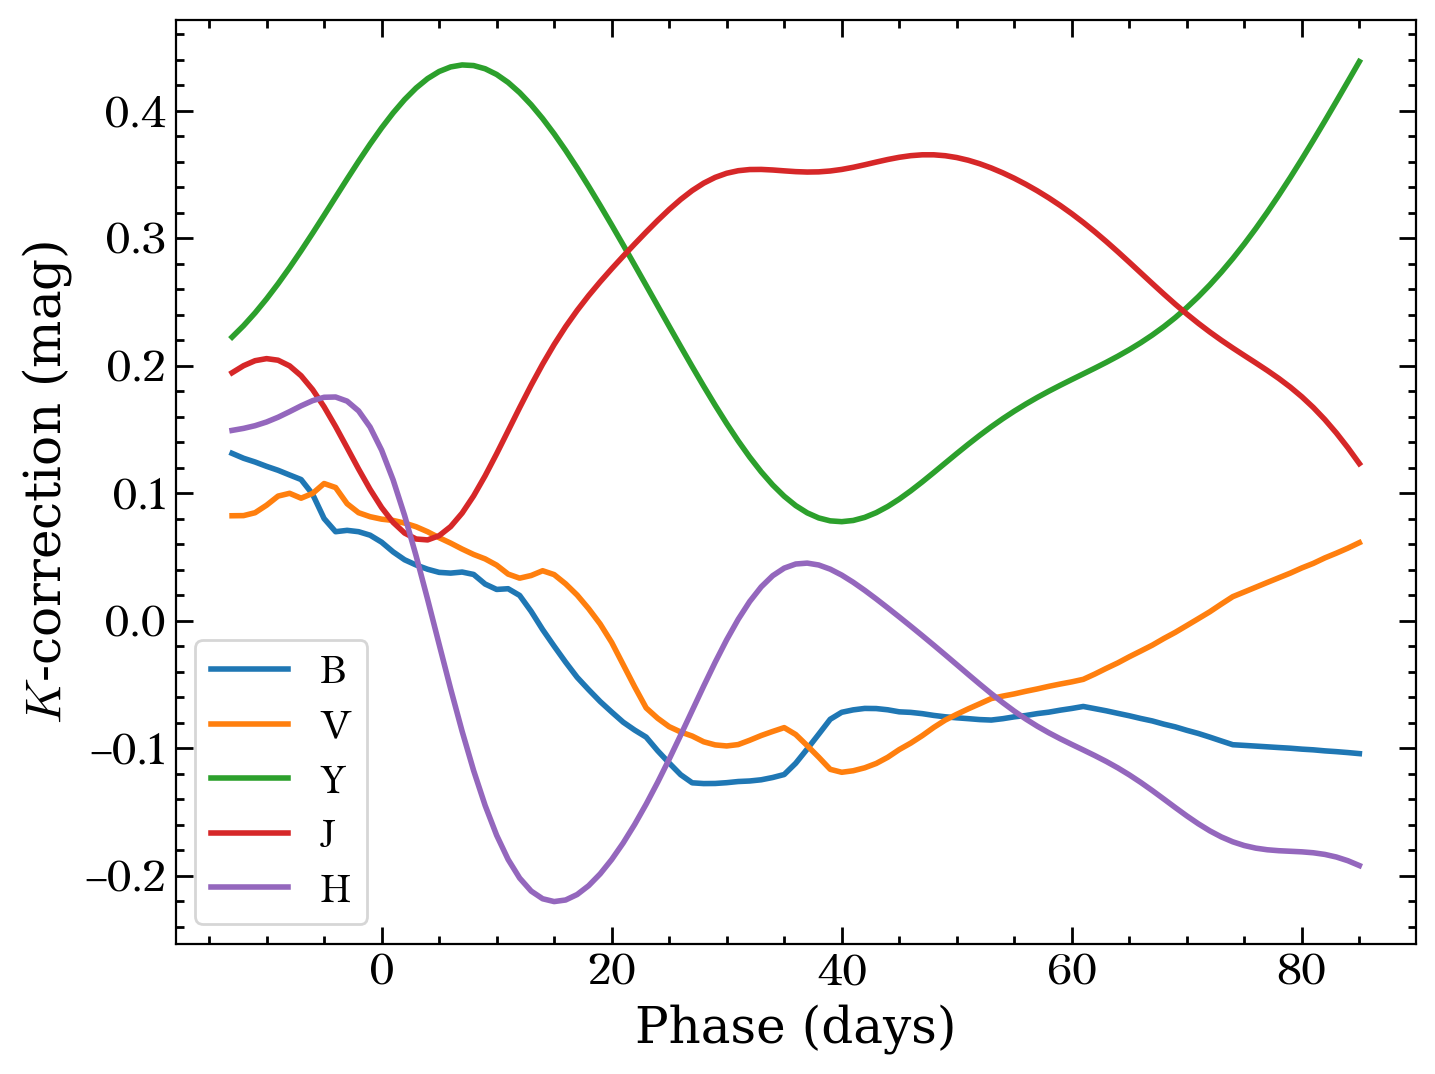

In [35]:
sed.plot_k_correction()

In [ ]:
sed.kcorr_evolution(bands='BR')

In [107]:
z = 0.03
sed = SEDTemplate(z, 'SNIa', bands='BVRIYJH')

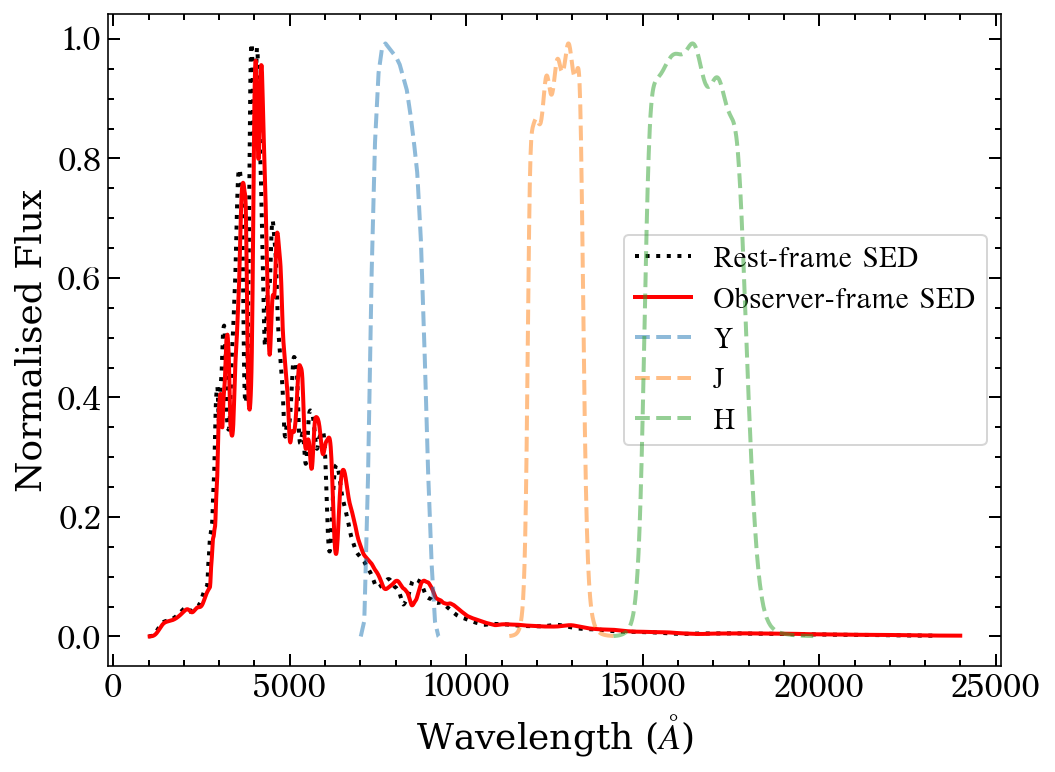

In [108]:
sed.plot_sed(bands='YJH')

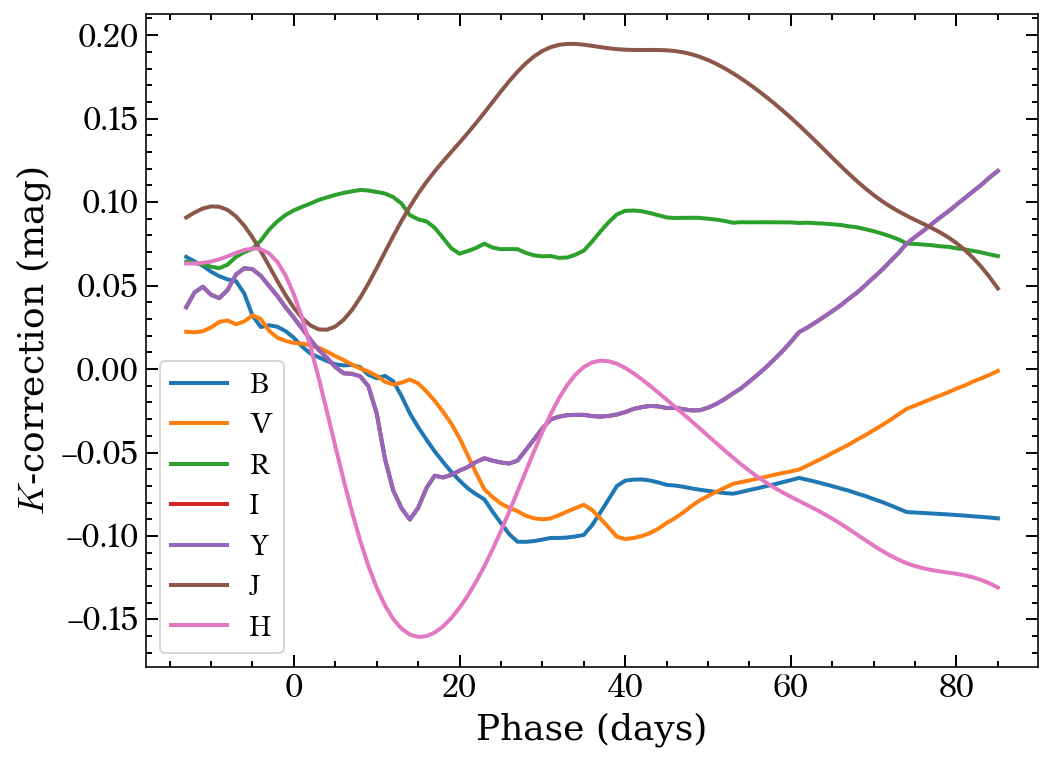

In [105]:
sed.plot_k_correction()